# Tackling Hyperinflammation, one Golgi at a time

### Done by: Austin, Justin, Hemant, Yuyan
### Special mentions to: Daniel Cheng (Mentor) and Dr Robert (Homie)

## 1. Background

### <ins>1.1 Lore of TNF-α</ins>
<img src="https://www.mdpi.com/ijms/ijms-24-06142/article_deploy/html/images/ijms-24-06142-g002-550.jpg" alt="TNF-α activation pathways" width="600"/><br>
Figure 1: Diagram describing the pathway involving TNF-α physiological's response.
* TNF-α is an inflammatory molecule (termed as cytokines), where it is secreted by cells under stress.
* It initiates inflammation by triggering a cascade of other inflammatory molecules which recruit immune cells to further drive 
inflammation.
* TNF-α levels will decrease rapidly after elimination of pathogens or undesired junk, causing cessation of inflammation.


### <ins>1.2 Synthesis pathway of TNF-α</ins>
<img src="Synthesis pathway of TNFa.png" alt="Synthesis pathway of TNF-α" width="600"/><br>
Figure 2: Schematic describing TNF-α synthesis, processing and export pathway.
* Here, an inflammatory stimuli is input from the surroundings.
* This will activate a transduction pathway, upregulating the expression of TNF-α in the cell. The TNF-α gene will be transcribed into mRNA, it will be translated in the cytoplasm by the ribosomes, forming a pre-protein (meaning immature protein).
* The pre-TNF-α, will be transported into the endoplasmic reticulum for processing, and subsequently be transported into Golgi apparatus based for further transporting, packing and finally, transport out of the cell.
* This transport is facilitated by Kinesin-1, which carries the package on the microtubules, out of the cell

### <ins>1.3 Implications of TNF-α in hyperinflammatory diseases</ins>
<img src="Cytokine storm.png" alt="Cytokine storm" width="600"/><br>
Figure 3: Simplified illustration of cytokine storm and its effects.
* Patients with hyperinflammatory diseases such as Rheumatoid Arthritis, Crohn's Disease, Psoriasis, where they exhibit excessive release of cytokines during inflammation, known as cytokine storm
* Following the excessive release of cytokines during inflammation, it causes hyperactivation of the immune system and (dangerously) high levels of inflammation. As it will also cause a release in TNF-α, it generates a positive feedback loop and further manifests the hyperinflammatory response.
* This damages healthy cells and tissues, increasing the risk of developing autoimmune diseases and organ damage (as such in Crohn's Disease)


### <ins>1.4 Existing Treatments</ins>
<img src="https://www.frontiersin.org/files/Articles/533034/fcell-08-00401-HTML/image_m/fcell-08-00401-g002.jpg" alt="Existing treatments for hyperinflammation involving TNF-α" width="600"/><br>
Figure 4: Different mechanisms of TNF-α activation. **(A)** Activation of TNFR1 and TNFR2 by membrane-bound TNF (mTNF), soluble TNF and LTα. **(B)** Global inhibition of TNFR1 and TNFR2 by anti-TNF antibodies and soluble TNFR2-Fc fusion proteins. **(C)** Selective inhibition of TNFR1 by anti-TNFR1 antibodies and dominant-negative TNFR1-selective TNF muteins. **(D)** Selective activation of TNFR2 by anti-TNFR2 antibodies and multivalent TNFR2-selective TNF muteins.
* Common treatments utilise neutralising antibodies that target TNF-α, blocking its interaction with TNF-α receptors on cell surfaces and this in turn, blocks the activation of TNF-α pathway described in Figure 1.
* However, they are not always effective as:
    * While they are effective at blocking the action of soluble TNF-α, it might be less effective at blocking membrane-bound TNF-α
    * They can only 1 out of the 2 types of TNF-α, thus limiting its action on mechanism


### <ins>1.5 Kinesin-1 plays a vital role in protein export</ins>
<img src="Kinesin-1 transporting TNFa.png" alt="Transporting of TNF-α via Kinesin-1" width="400"/><br>
Figure 5: Mechanism of Kinesin-1.
* Processed proteins are packaged in Golgi, where they are loaded onto Kinesin-1.
* Kinesin-1 is an export protein, which travels unidirectionally outward along web-like microtubule scaffold within the cells, from Golgi to outside of the cell.
* Kinesore inhibits Kinesin-1, prevent the action of Kinesin-1 and stops protein export out of the cell. Thus, this drug was employed to investigate its use, and potential therapeutic targets for future drugs.


## 2. Robert's Golgi

### <ins>2.1 Experimental outline</ins>
<img src="Kinesin-1 transporting TNFa fusion.png" alt="Transporting of TNF-α-SBP-GFP fusion protein via Kinesin-1" width="400"/><br>
Figure 6: Mechanism of Kinesin 1 transporting the recombinant TNF-α-SBP-GFP fusion protein.
* Dr Robert studied TNF-α trafficking to propose potential therapeutic targets that intervene and stop hyperinflammatory response in patients
* Our goal here is to investigate whether a drug (kinesore) that can ***dampen the inflammatory response, but not fully eliminate it as inflammation is still required for normal homeostatic processes*** within the body, such as clearing of cell debris etc.
* Here, Dr Robert utilised kinesore as a proof-of-concept that it can regulate magnitude of protein export. Degree of regulation depends on concentration of kinesore used.
* By disrupting Kinesin-1, we regulate the trafficking of TNF-α.

<img src="HeLa cells.png" alt="HeLa Cells" width="400"/><br>
Figure 7: Brightfield image of HeLa cells at high density.
* HeLa cells, which are immortal human cells isolated from the cervix of a woman with adenocarinoma, were used in this study due to:
    * Endless ability to undergo cell division
    * Easy to be transfected with virus containing plasmid of interest
    * Low cost and easy maintenance of cell line


### <ins>2.2 Incorporation of RUSH system</ins>
<img src="Incorporation of RUSH system.png" alt="Incorporation of RUSH system" width="800"/><br>
Figure 8: Schematic of Retention Using Selective Hooks (RUSH) system incorporated into human cervical adenocacinoma.
* A plasmid with constitutive promoters are designed, containing conding sequences for:
    * TNF-α, tagged to streptavidin binding protein (SBP) and Green Fluorescence Protein (GFP)
    * KDEL-streptavidin
        * KDEL refers to the alphabetical representative of the amino acids it code for: Lysine, Aspartic Acid, Glutamic Acid and Leucine respectively.
        * These specific amino acid sequences serve as an endoplasmic reticulum retention signal, where proteins tagged with these are retained in the endoplasmic reticulum. In our case, streptavidin is tagged with KDEL sequence and will be immobilised in the endoplasmic reticulum, which will come in handy later.
* The recombinant plasmid is then packaged into a lentivirus, where it is further added to our HeLa cells for transfection. Lentiviruses are retroviruses which has robust capacity to infect a wide variety of mammalian cells, and release their genetic material into the host cell for virus propagation.
* In our case, the transfection allows for the introduction of our recombinant plasmid into our cells in the study, where the sequences on the plasmid will get expressed due to the involvement of a constitutive promoter.
* As the TNF-α-SBP-GFP and KDEL-streptavidin gets transcribed and translated, KDEL-streptavidin will get immobilised in the endoplasmic reticulum, where due to the affinity of streptavidin and SBP from the TNF-α-SBP-GFP protein, they will interact and cause the trapping of TNF-α-SBP-GFP in the endoplasmic reticulum. This prevents future processing and trafficking of the TNF-α-SBP-GFP protein.
* Biotin is a protein where it readily enters the cell through transporters. They possess high affinity for streptavidin due to its complementary shape and possessing extraordinarily high dissociation constant, making their interaction one of the strongest amongst the group of non-covalent interactions.
* As such, as biotin is added into the cell culture media, it enters the cell and endoplasmic reticulum and binds to streptavidin. This interaction displaces the interaction and dissociates streptavidin from TNF-α-SBP-GFP, releasing TNF-α-SBP-GFP.
* TNF-α-SBP-GFP will then be further transported to the Golgi apparatus for processing, packaging and sorting, where it will ultimately be transported out for secretion through Kinesin-1 and the web-like microtububle scaffold.
* As mentioned in Section 1.5, kinesore inhibits the mechanism of Kinesin-1, blocking the cellular railway road that transports proteins out from the Golgi apparatus to the exterior of the cell.
* In our case, we wanted to investigate whether:
    1. The cells are responsive to the drug
    2. To what extent
* We will investigate this in the following segments and break it down pythonically for you.


### 2.3 Raw data provided by Dr Robert
If you have an SPS Gmail acocunt, kindly click on the link to access the videos, or refer to "Videos" folders of the current working directory to see the raw videos as we are unable to insert videos into markdown cells.

<ins>Kinesore Treatment</ins><br>
[0µM Kinesore Treatment](https://drive.google.com/file/d/19iW9pfbHawVdfHsKhJd2ClJoIa2KfCc5/view?usp=sharing)<br>
[25µM Kinesore Treatment](https://drive.google.com/file/d/15jdvnvvfNW8UyuxQEalk8l7FAb7GMFiF/view?usp=sharing)<br>
[50µM Kinesore Treatment](https://drive.google.com/file/d/1M-WMVi3Dne7ue15XITkMr7wIgeeG0Kpl/view?usp=sharing)<br>

<ins>Plasmid concentration optimisation with Kinesore</ins><br>
[0.5µg DNA Treatment with 10µM Kinesore](https://drive.google.com/file/d/1XbFDt9NVdICsWwozt_rzobdFINti1YB9/view?usp=sharing)<br>
[0.75µg DNA Treatment with 10µM Kinesore](https://drive.google.com/file/d/1nDE82Hn1euPJ5rw_1z0IU1JwFt_io9uG/view?usp=sharing)<br>
[1µg DNA Treatment with 10µM Kinesore](https://drive.google.com/file/d/1nvAA5RUQVJsc-xPS2i0s5Pg0aJseu00M/view?usp=sharing)<br>

* Based on all the videos (less 50µM Kinesore Treatment), intially, we observe GFP from TNF-α-SBP-GFP protein to be scattered in the cell. This is due to endoplasmic reticulunm being located throughout the cell. There, TNF-α-SBP-GFP are retained in the endoplasmic reticulum.
* Upon the addition of biotin (performed at *time = 0* in all conditions), it will cause the release of TNF-α-SBP-GFP protein from the endoplasmic reticulum as described in Section 2.2. TNF-α-SBP-GFP proteins will then move into the Golgi apparatus rapidly and causes an accumulation as the Golgi apparatus can only process, package and send the proteins for transportation at a fixed rate.
* As TNF-α-SBP-GFP proteins are transported out of the cell, we will observe a decrease in GFP signal due to the released protein being
    * Dispersed in the cell culture media
    * Not being at the same Z plane of the cell, confocal microscope cannot capture
    * Unfolding and degradation due to absence of stabilising molecules that are found within the cell
* For the videos directed at optimising plasmid concentrations, the concentrations are investigated as:
    * Using too high of plasmid concentration will cause cells to exhibit toxicity and insufficient.
    * Using too low of plasmid concentration will result in insufficient protein expression.
* Both of which will give undesirable consequences.

### 3. Methods & Results
<img src="Project workflow.png" alt="Project workflow" width="600"/><br>
Figure 9: Schematic of project workflow
* We received videos from Dr Robert in .avi format, where these videos are essentially 1 hour and 45 minute timelapses with 1 frame taken every 5 minutes.
* Manually shifted the videos into a folder "Videos".
* Created a function where it will read the .avi files inside the "Videos" folder, where it will create folders based on the filename. Subsequently, it will split the videos into frames.
* Manually sieved through the folders and deleted aberrant frames. They are either blank, or duplicated glitched frames.
* Using [SciPy Fit](http://scipy.fit/), we identified the Golgi Apparatus for each video and noted down the (y1, y2, x1, x2). Some of the videos had multiple cells, where we identified multiple ROIs.
    * These regions of interested were identified by looking through the individual frames per video, where we observe for cells that exhibit the accumulation of GFP, where we assumed that it is indeed the Golgi.
    * We further extrapolate this onto other videos, and also multiple cells within each videos (if applicable).
* Converted the images to Grayscale, and cropped them based on their respective ROIs.
    * <img src="ROI and cropping.png" alt="ROI and Cropping" width="400"/><br>
* Set a threshold for each frame for each video, and disregarded the points below.
* Process the video. In our case, we applied weighted average
    * <img src="Weighted average diagram.png" alt="Weighted Average Diagram" width="400"/><br>
    * The idea was to identify the regions where the Golgi is *most* likely to be located at (which is determined by our ROI), which we can achieve this by
        * Assigning a higher weight to pixels where the Golgi is more likely to be located.
        * Assigning a lower weight to pixels where the Golgi is less likely to be located.
* Plot the different graphs to observe trends
    * Sum of fluorescence - Compiled plots of all the video files and frames, normalised to the maximum sum of fluorescence signal for that video.
    * Different data processing methods - Here, we showed the different normalisation methods to better visualise the changes in fluorescence levels, whilst maintaining its integrity as an array (Not butchering it by reducing noise drastically)
    * Based on the plots above, we chose a data processing method which best visualises the phases we previously identified for accumulation and subsequent dispersion phases.
    * We attempted to apply a gradient descent algorithm for linear regression modelling onto our dataset, where we ploted the best-fit model for all the videos and chosen to show two specific videos with best-fit lines (0.75µg DNA Treatment with 10µM Kinesore, ROI [0]), (1µg Biotin, 0µM Kinesore, ROI [0])
<img src="0.75ugDNA_drug10uM_5min45min_1_ROI 0.png" alt="0.75ugDNA_drug10uM_5min45min_1_ROI 0" width="500"/><br>
<img src="LipoKDEL1ug_biotin_no drug_live_5min1h_ROI 0.png" alt="LipoKDEL1ug_biotin_no drug_live_5min1h_ROI 0" width="500"/><br>

#### Compiled data for best-fit lines
  | Video                                                             | ROI   | Gradient             | Intercept         | r2 values         |
|-------------------------------------------------------------------|-------|----------------------|-------------------|-------------------|
| 0.5ug DNA, 10uM drug                                              | 0     | -0.028               | 1.178             | 0..983            |
| 0.75ug DNA, 10uM drug 0.75ug DNA, 10uM drug 0.75ug DNA, 10uM drug | 0 1 2 | -0.018 -0.024 -0.025 | 1.091 1.097 0.980 | 0.958 0.962 0.854 |
| 1ug DNA, 10uM drug  1ug DNA, 10uM drug                            | 0 1   | -0.040 -0.031        | 1.360 0.856       | 0.902 0.673       |
| 1ug biotin, 25uM drug 1ug biotin, no drug                         | 0 0   | -0.011 -0.018        | 1.095 1.108       | 0.763 0.995       |
| 1.5ug biotin, 50uM drug 1.5ug biotin, 50uM drug                   | 0 1   | -0.001 -0.012        | 0.934 0.827       | 0.089 0.526       |

In [34]:
import os, glob, shutil, cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy.stats import linregress
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold, threshold_minimum, threshold_isodata
import skimage.measure as measure

#Extracting frames from video using cv2 package

In [35]:
#find videos
print(f'Current directory: {os.getcwd()}')

path_to_videos = glob.glob(os.path.join('Videos','*.avi'))
print(path_to_videos, '-'*10, sep = '\n')
#create required directories
def makefolders(path):
    folder = os.path.split(path) #create folders for extracting all images
    folder = os.path.splitext(folder[-1])
    folder_create = os.path.join('Videos',folder[0])
    if os.path.exists(folder_create) == False:
        os.mkdir(folder_create)
    else:
        pass
    return folder_create

#navigate into folder for the image and save images
def saveimages(path, dir_name):
    cam = cv2.VideoCapture(path)
    count, success = 0, True
    video_index = []
    while success:
        success, image = cam.read()
        if not cam.isOpened():
            print(f"Error: Could not open video file {path}")
        os.chdir(dir_name)
        if success:
            folder = os.path.split(dir_name)
            frame = f'{folder[-1]}_frame_{count:02}.jpg'
            video_index.append(frame)
            if os.path.exists(frame) == False:
                cv2.imwrite(frame, image)
                print(f'{frame} successfully saved')
                count+=1
            else:
                print(f'{frame} already exists, skipping save')
                count+=1
        else:
            print('End of file')
        os.chdir(os.path.join('..','..'))
    cam.release()
    print(f'Current directory: {os.getcwd()} \n Completed {path}\n--------------------')
    return video_index

Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project
['Videos\\0.5ugDNA_drug10uM_5min45min_1.avi', 'Videos\\0.75ugDNA_drug10uM_5min45min_1.avi', 'Videos\\1ugDNA_drug10uM_5min45min_1.avi', 'Videos\\LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi', 'Videos\\LipoKDEL1ug_biotin_no drug_live_5min1h.avi', 'Videos\\XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h.avi', 'Videos\\XtremeStr-li1.5ug_biotin_no drug_live_5min45min.avi']
----------


In [36]:
video_indexes, folder_indexes = [], []
vf_dict = {}
for path in path_to_videos:
    dir_name = makefolders(path)
    folder_indexes.append(dir_name)
    img_names = saveimages(path, dir_name)
    video_indexes.append(img_names)
    vf_dict[os.path.split(dir_name)[-1]] = img_names

#show structure of the dictionary
for key, item in vf_dict.items():
    print(key, item, '\n')

0.5ugDNA_drug10uM_5min45min_1_frame_00.jpg already exists, skipping save
0.5ugDNA_drug10uM_5min45min_1_frame_01.jpg already exists, skipping save
0.5ugDNA_drug10uM_5min45min_1_frame_02.jpg already exists, skipping save
0.5ugDNA_drug10uM_5min45min_1_frame_03.jpg already exists, skipping save
0.5ugDNA_drug10uM_5min45min_1_frame_04.jpg already exists, skipping save
0.5ugDNA_drug10uM_5min45min_1_frame_05.jpg already exists, skipping save
0.5ugDNA_drug10uM_5min45min_1_frame_06.jpg already exists, skipping save
0.5ugDNA_drug10uM_5min45min_1_frame_07.jpg already exists, skipping save
0.5ugDNA_drug10uM_5min45min_1_frame_08.jpg already exists, skipping save
0.5ugDNA_drug10uM_5min45min_1_frame_09.jpg already exists, skipping save
End of file
Current directory: C:\Users\austi\Documents\learning-portfolio-2024-aug-immunoglobulinaustin\final_group_project 
 Completed Videos\0.5ugDNA_drug10uM_5min45min_1.avi
--------------------
0.75ugDNA_drug10uM_5min45min_1_frame_00.jpg already exists, skipping sa

#Process fluorescence data - First pass

In [48]:
# Functions for extracting and plotting the raw data
cwd = os.getcwd() #getting current working directory

folders_to_process = ('LipoKDEL1ug_biotin_no drug_live_5min1h',  'LipoKDEL1ug_biotin_drug25uM_live_5min1h',
                      'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h',
                      '0.5ugDNA_drug10uM_5min45min_1', '0.75ugDNA_drug10uM_5min45min_1', '1ugDNA_drug10uM_5min45min_1')

region_of_interest = {'0.5ugDNA_drug10uM_5min45min_1': [(300,500, 400,600)],
           '0.75ugDNA_drug10uM_5min45min_1': [(300,475, 375,550),(690,780, 400,500), (530,630, 530,630)],
           '1ugDNA_drug10uM_5min45min_1': [(400,550, 180,300),(695,790, 655,725)],
           'LipoKDEL1ug_biotin_drug25uM_live_5min1h': [(625,740, 600,720)],
           'LipoKDEL1ug_biotin_no drug_live_5min1h': [(550,690, 450,600)],
           'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h': [(285,400, 70,150),(615,675, 650,715), (170,260, 970,1024)]
}

golgi_frame = {'0.5ugDNA_drug10uM_5min45min_1': '0.5ugDNA_drug10uM_5min45min_1_frame_03.jpg',
           '0.75ugDNA_drug10uM_5min45min_1': '0.75ugDNA_drug10uM_5min45min_1_frame_02.jpg',
           '1ugDNA_drug10uM_5min45min_1': '1ugDNA_drug10uM_5min45min_1_frame_03.jpg',
           'LipoKDEL1ug_biotin_drug25uM_live_5min1h': 'LipoKDEL1ug_biotin_drug25uM_live_5min1h_frame_06.jpg',
           'LipoKDEL1ug_biotin_no drug_live_5min1h': 'LipoKDEL1ug_biotin_no drug_live_5min1h_frame_04.jpg',
           'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h': 'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_06.jpg'
              }

#creating a function called extract_fluorescenceData, to loop through the 7 different folders.
def extract_fluorescenceData(folder_path, img_order, resolutions):
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function

def histogrammer(video1, n, i=0, label = False): #video1 is an array of the max fluorescence values, i simply stands for index
    video1_normalise = video1/max(video1) #normalising to highest sum fluorescent signal in the frames.
    name = os.path.split(n) #split it by \\ into index, where [0] = your directory and [i] in this case is folder names
    x = range(1, len(video1)+1) #plotting frame 1 to n+1

    #plotting segment
    if label == True:
        plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o', label = 'Original Data') #marker is the data point, marked as circle.
    else:
        plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o', label = f'{name} ROI {i}')
    #Labels & aesthetics
    # plt.xticks(x) #this makes it show every tick in X axis
    plt.xlabel('Frame number', fontsize = 10)
    plt.ylabel('Total fluorescence signal', fontsize = 10)
    plt.grid(alpha = .25)
    plt.tight_layout()


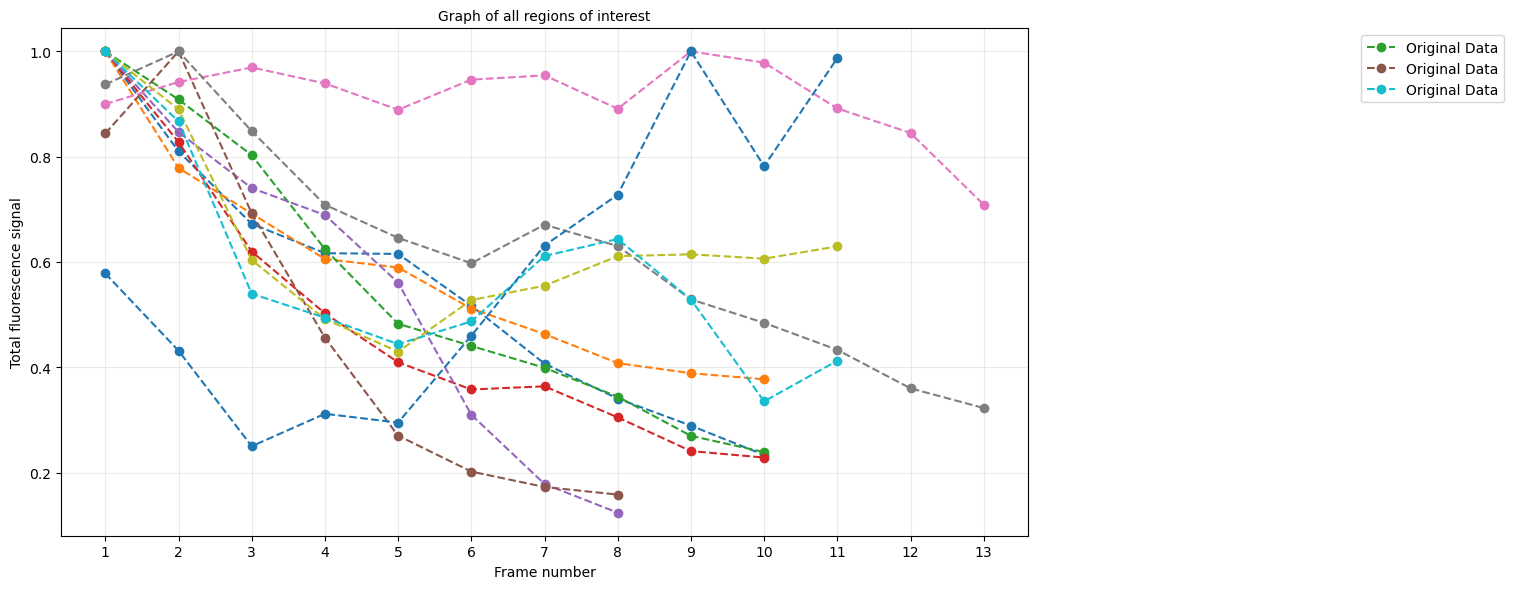

In [45]:
longest_video = 0
plt.figure(figsize =(20,6))
for key in region_of_interest.keys():
    for i in range(len(region_of_interest[key])):
        video1 = extract_fluorescenceData(key, vf_dict[key], region_of_interest[key][i])
        if longest_video < len(video1):
            longest_video = len(video1)
        histogrammer(video1, key, i)
plt.title('Graph of all regions of interest', fontsize = 10)
plt.xticks(np.arange(1,longest_video+1))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.5,1))
plt.tight_layout()
plt.savefig(f'Graph of all regions of interest', format = 'jpg')
plt.show()

# Attempting to assess the cropping of the images

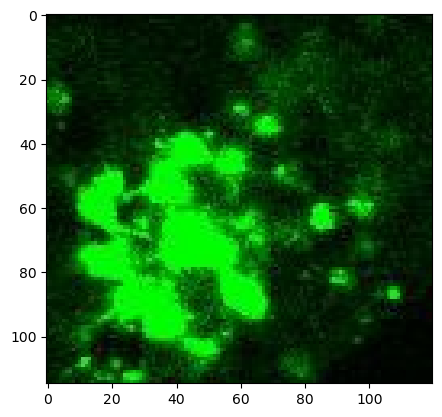

In [18]:
#goal: identify green regions and calculate area to intensity ratio for lipoKDEL1ug_biotin_drug25uM
video = {'LipoKDEL1ug_biotin_drug25uM_live_5min1h': (625,740, 600,720)}

img_path = 'LipoKDEL1ug_biotin_drug25uM_live_5min1h_frame_03.jpg'
img = plt.imread(os.path.join('Videos',list(video.keys())[0], img_path))
img = img[625:740,600:720]

plt.imshow(img)

img_grey = rgb2gray(img)
plt.show()

12078.0
---------- Region 0 ----------
Centre	: (54.999254843517136, 62.18065904951151)
Area	: 12078.0


---------- Region 1 ----------
Centre	: (84.0, 34.0)
Area	: 1.0




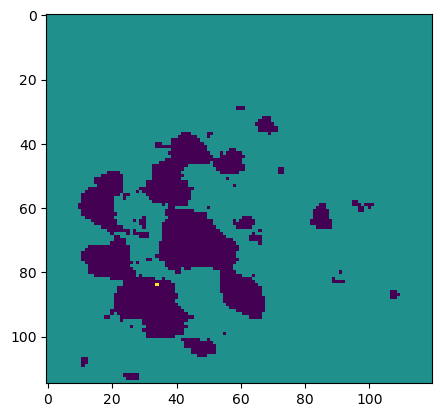

In [19]:
threshold = threshold_minimum(img_grey)
img_binarised = img_grey < threshold

img_labelled = measure.label(img_binarised.astype('uint8'))
plt.imshow(img_labelled)
 # measure.label() requires an image of type int
img_labelled = measure.label(img_binarised.astype('uint8'))
region_info = measure.regionprops(img_labelled)
print(region_info[0].area)

no_of_regions = len(region_info)

for count, region in enumerate(region_info):
    print('-'*10, f'Region {count}', '-'*10)
    print(f'Centre\t: {region.centroid}')
    print(f'Area\t: {region.area}')
    print('\n')

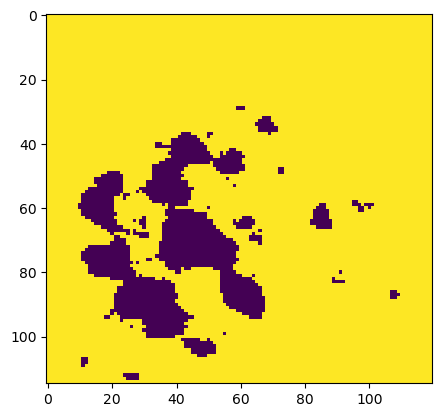

In [20]:
img_masked = img_labelled == 1
plt.imshow(img_masked)
plt.show()

In [49]:
def ratio_Data(folder_path, img_order, resolutions): #attempting to find fluorescence/area ratio
    total_fluorescence, areas = [], []
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path):
            # if img.lower().endswith('.jpg'): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]

                try:
                    threshold = threshold_minimum(cropped_img)
                    binarised_img = cropped_img < threshold
                    img_labelled = measure.label(binarised_img.astype('uint8'))
                    region_info = measure.regionprops(img_labelled)

                    total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
                    areas.append((y2-y1)*(x2-x1) - region_info[0].area)
                except RuntimeError:
                    print(f'Error with {img} image')
                    pass
    else:
        print(f'Subdirectory {video_folders} not found')
    ratio = np.array(total_fluorescence)/np.array(areas)
    return ratio

def overlay_threshold(folder_path, img_order, resolutions, return_base = True):
    total_fluorescence, areas = [], []
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration
    y1, y2, x1, x2 = resolutions
    overlay = np.zeros((y2-y1,x2-x1))

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path):
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                cropped_img = img_gray[y1:y2, x1:x2]
                cropped_img = noise_remove(cropped_img)
                overlay+=cropped_img

    else:
        print(f'Subdirectory {video_folders} not found')
    if return_base == True:
        return extract_Data(folder_path, img_order, resolutions, overlay), overlay
    else:
        return overlay

def extract_Data(folder_path, img_order, resolutions, overlay, use_threshold = False, reference = None):
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration
    if use_threshold == True and reference != None:
        threshold = extract_threshold(folder_path, resolutions, reference)

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]
                cropped_img = noise_remove(cropped_img)
                if use_threshold == True:
                    cropped_img[cropped_img < threshold] = 0
                cropped_img *= overlay
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence

def extract_thresholdData(folder_path, img_order, resolutions, reference):
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration
    threshold = extract_threshold(folder_path, resolutions, reference)
    y1, y2, x1, x2 = resolutions

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                cropped_img = img_gray[y1:y2, x1:x2]
                cropped_img[cropped_img<threshold] = 0
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence

def extract_threshold(folder_path, resolutions, reference):
    ref_path = os.path.join(cwd, 'Videos', folder_path, reference)
    img_ref = plt.imread(ref_path)

    #reference threshold
    img_ref = rgb2gray(img_ref)
    y1, y2, x1, x2 = resolutions
    img_ref_cropped = img_ref[y1:y2, x1:x2]
    threshold = threshold_isodata(img_ref_cropped)
    return threshold

def power_overlay(overlay):
    overlay = overlay**4
    return overlay

def norm_overlay(overlay):
    overlay = overlay/np.max(overlay)
    return overlay

def get_label(filepath):
    # x=list(region_of_interest.keys())[4]
    label=[fragments for fragments in filepath.split('_') if 'drug' in fragments]
    return label[0].upper()

def noise_remove(img):
    mask = img < 0.15
    img[mask] = 0
    return img

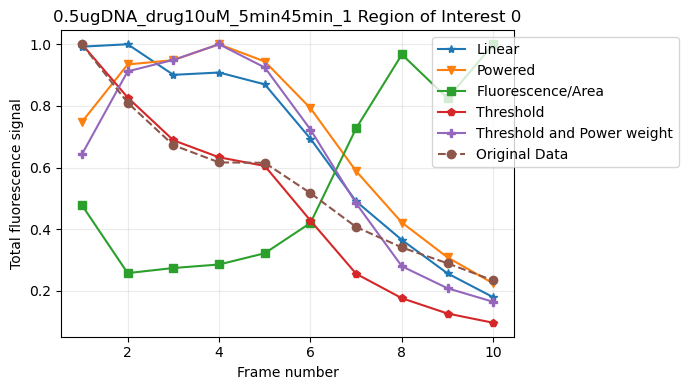

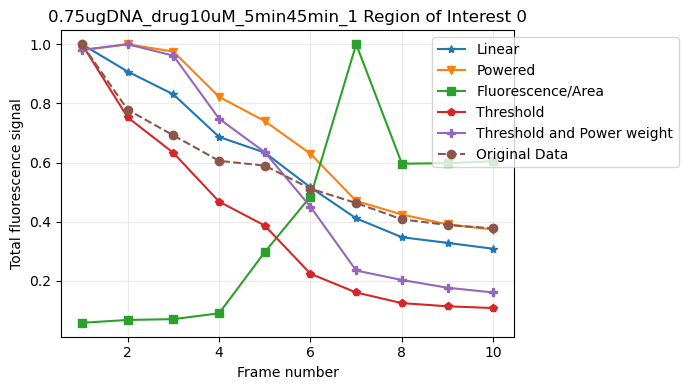

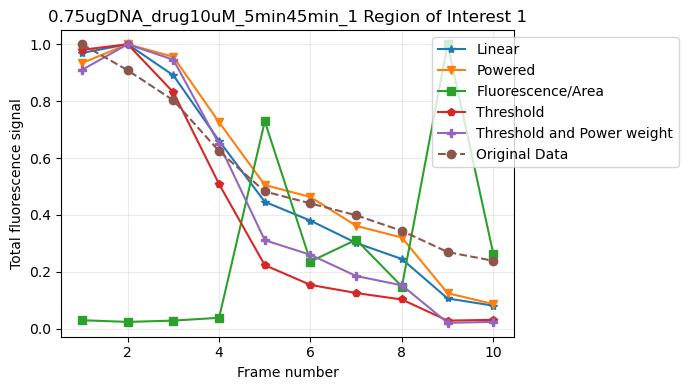

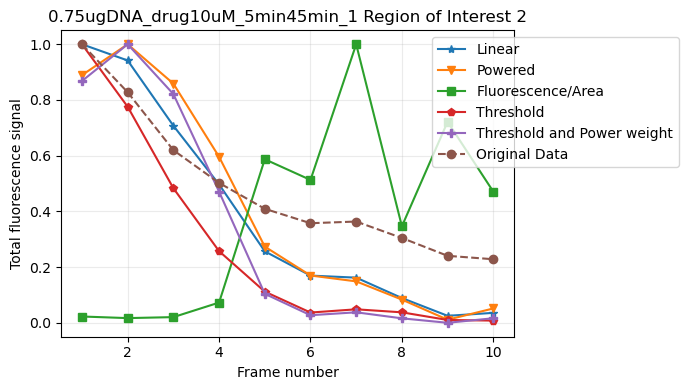

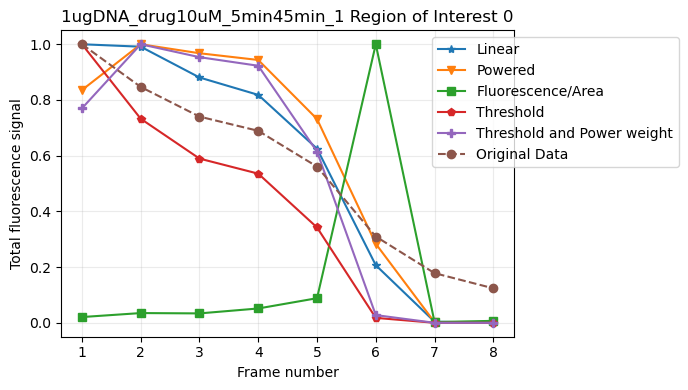

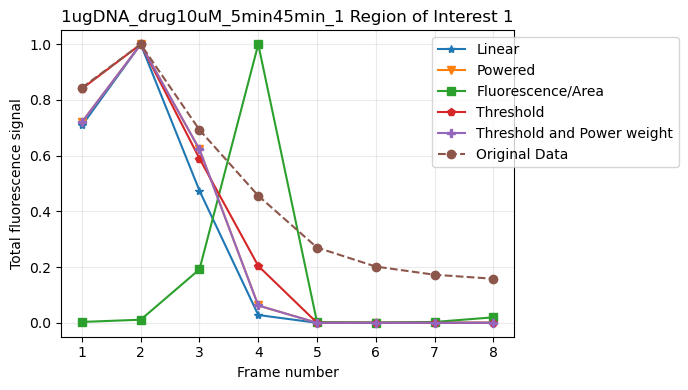

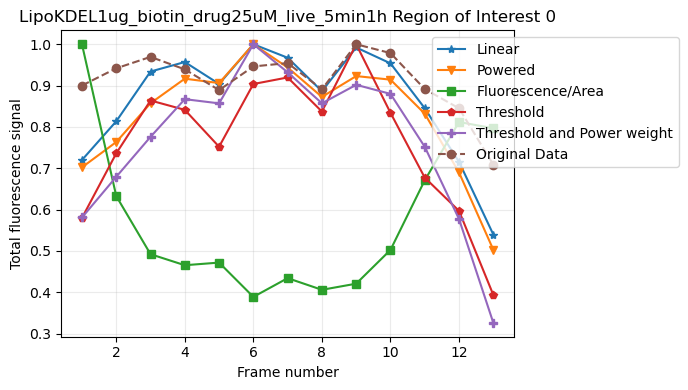

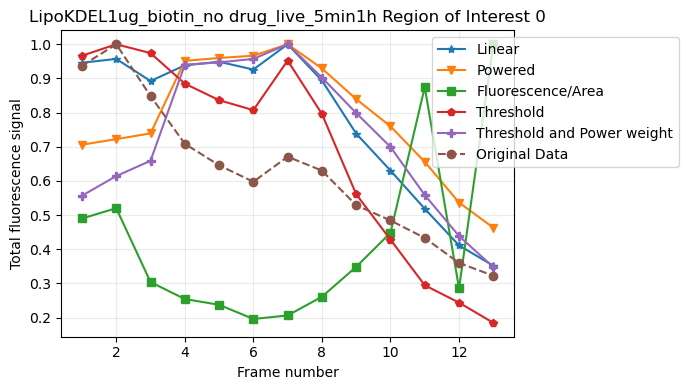

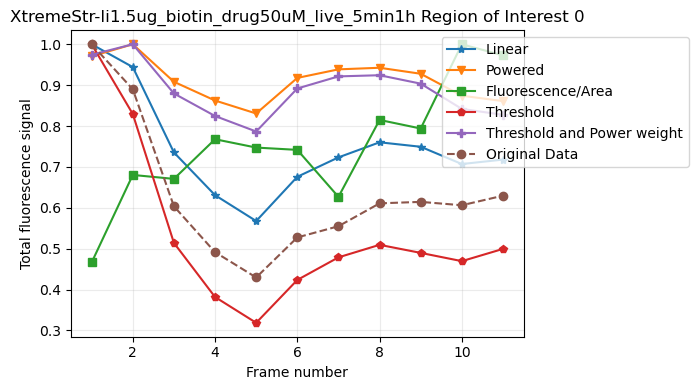

Error with XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_04.jpg image


ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

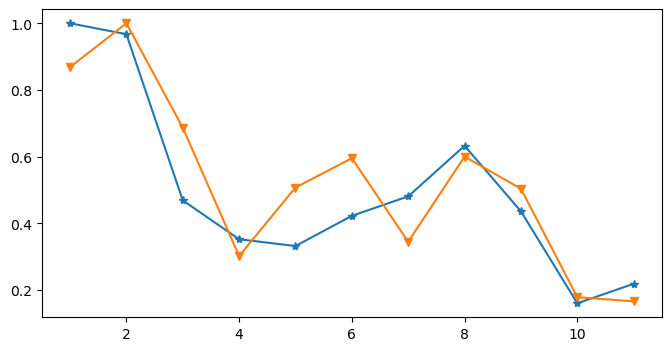

In [50]:
# This cycles through all video folders and creates the graphs
for key in region_of_interest:
    for i in range(len(region_of_interest[key])):
        video1 = extract_fluorescenceData(key, vf_dict[key], region_of_interest[key][i])

        #first overlay without any configuration to heat map
        img_overlay, overlay = overlay_threshold(key, vf_dict[key], region_of_interest[key][i])
        img_overlay = img_overlay/max(img_overlay)

        #increasing the heat map by power of 4, not 2. squared is just an old name and im lazy
        overlay1 = power_overlay(overlay)
        img_squared = extract_Data(key, vf_dict[key], region_of_interest[key][i], overlay1)
        img_squared = img_squared/max(img_squared)

        #this is normalising the heat map, but it does the same as the first function
        overlay2 = norm_overlay(overlay)
        img_norm = extract_Data(key, vf_dict[key], region_of_interest[key][i], overlay2)
        img_norm = img_norm/max(img_norm)

        #fluorescence of ratio
        ratio_f = ratio_Data(key, vf_dict[key], region_of_interest[key][i])
        ratio_f = ratio_f/max(ratio_f)

        img_mask = extract_thresholdData(key, vf_dict[key], region_of_interest[key][i], golgi_frame[key])
        img_mask = img_mask/max(img_mask)

        threshold_weighted = extract_Data(key, vf_dict[key], region_of_interest[key][i], overlay1,
                                          use_threshold = True, reference = golgi_frame[key])
        threshold_weighted = threshold_weighted/max(threshold_weighted)

        frames = np.arange(1,len(img_overlay)+1)
        plt.figure(figsize = (8,4))
        plt.plot(frames, img_overlay, label = "Linear", linestyle = 'solid', marker = '*')
        plt.plot(frames, img_squared, label = "Powered", linestyle = 'solid', marker = 'v')
        plt.plot(frames, ratio_f, label = 'Fluorescence/Area', linestyle = 'solid', marker = 's')
        plt.plot(frames, img_mask, label = 'Threshold', linestyle = 'solid', marker = 'p')
        plt.plot(frames, threshold_weighted, label = "Threshold and Power weight", linestyle = 'solid', marker = 'P')
        histogrammer(video1, key, i, label = True) #reusing previous code
        plt.title(f'{key} Region of Interest {i}')
        plt.legend(loc = 'upper right', bbox_to_anchor = (1.38,1))
        plt.tight_layout()
        plt.savefig(f'{key} Region of Interest {i}', format = "jpg")
        plt.show()

#Assessing the rate of export of TNF
Likely will require data on how fluorescence levels correspond to GFP levels to create a calibration curve.

While we are not able to assess exactly how fast it is exported and express it in terms of concentration per unit time, we can still assess whether the rate of export is linearly related or if other mathematical equations may better suit the rate of export.

In [ ]:
#chosen function: power
def linear_relation(t,m,c):
    export = m*t + c
    return export

def dcdt(t,m,c,f_actual): #vary b0
    f_predicted = linear_relation(t,m,c)
    a = np.sum(f_actual - f_predicted)
    b = -2/len(f_actual)
    const = a * b
    return const

def dmdt(t,m,c,f_actual): #vary b1
    f_predicted = linear_relation(t,m,c)
    a = np.sum((f_actual - f_predicted) * t)
    b = -2/len(f_actual)
    gradient = a * b
    return gradient

def get_lineEqn(m, c, t, f_i, max_iter=10000, lr = 1e-4, tol = 1e-5):
    for _ in range(max_iter):
        diff1 = dcdt(t,m,c,f_i)*lr
        diff2 = dmdt(t,m,c,f_i)*lr
        if abs(diff1) < tol and abs(diff2) < tol:
            break
        else:
            c-=diff1
            m-=diff2
    return m,c

def rss(y_predicted, y_actual):
    return np.sum((y_actual-y_predicted)**2)

def tss(y_predicted, y_actual):
    y_ave = np.average(y_actual)
    return np.sum((y_predicted-y_ave)**2)

def r2calc(y1, ya):
    r2 = 1 - (rss(y1,ya)/tss(y1,ya))
    return r2

In [ ]:
# We are calling both scipy's linear regression function, and our own linear
# regression model that is seen in get_lineEqn().
for key in region_of_interest.keys():
    for i in range(len(region_of_interest[key])):
        heat_map = overlay_threshold(key, vf_dict[key], region_of_interest[key][i], return_base = False)
        weighted_fluorescence = extract_Data(key, vf_dict[key], region_of_interest[key][i], power_overlay(heat_map))
        weighted_fluorescence = weighted_fluorescence/np.max(weighted_fluorescence)
        max_index = np.where(weighted_fluorescence == np.max(weighted_fluorescence))
        export = weighted_fluorescence[max_index[0][0]:]
        frames = np.arange(max_index[0][0],len(weighted_fluorescence))
        t = (np.arange(1,len(export)+1))*5
        plt.plot(frames, export, '.')
        plt.title(f'{key} \nRegion of Interest {i} \n{region_of_interest[key][i]}')

        function = linregress(t,export, alternative = 'less')
        line = linear_relation(t, function.slope, function.intercept)
        plt.plot(frames, line, label = r'export = {:.3f}t + {:.3f}, $r^2$ = {:.3f}'.format(function.slope,function.intercept,function.rvalue**2))

        m, c = get_lineEqn(m=-1,c=1, t=t, f_i = export)
        my_line = linear_relation(t,m,c)
        r2 = r2calc(my_line, export)
        plt.plot(frames, my_line, label = r'export = {:.3f}t + {:.3f}, $r^2$ = {:.3f}'.format(m, c, r2), linestyle = 'dashed')
        plt.legend(loc = 'upper right')
        plt.show()